<a href="https://colab.research.google.com/github/edithluv/Debunking_Market_Myths_Capstone_Project_Submission/blob/main/Adaptive_Quantitative_Strategies_A_Regime_Switching_Framework_to_Debunk_Market_Myths_and_Optimize_Asset_Allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# Python Code: Markov Switching Model (Transition Matrix Fix)
import numpy as np
import pandas as pd
import statsmodels.api as sm
# Ensure the correct import path for newer statsmodels versions
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
import yfinance as yf
import traceback # Import traceback for detailed error info
import sys # For potentially exiting on critical errors

# --- Configuration ---
ticker = '^GSPC'
start_date = '2000-01-01'
end_date = '2024-01-01'
n_regimes = 4 # <<< Changed to 4 regimes to align with thesis

# --- Data Acquisition ---
print(f"Attempting to download data for {ticker}...")
try:
    # Download data
    data_raw = yf.download(ticker, start=start_date, end=end_date)
    if data_raw.empty:
        raise ValueError(f"Failed to download data for {ticker}. DataFrame is empty.")
    print("Data downloaded successfully.")
    data = data_raw.copy() # Work with a copy
    print(f"Initial columns type: {type(data.columns)}")
    print(f"Initial columns: {data.columns}")

    # --- Handle Potential MultiIndex ---
    if isinstance(data.columns, pd.MultiIndex):
        print("Detected MultiIndex columns. Attempting to simplify...")
        original_columns = data.columns.tolist()
        # Ensure column names are strings before joining
        data.columns = ['_'.join(map(str, col)).strip() for col in data.columns.values]
        print(f"Flattened columns: {data.columns}")
        # Find the correct price column name after flattening
        adj_close_flat = 'Adj Close' + '_' + ticker
        close_flat = 'Close' + '_' + ticker
        possible_price_cols = [col for col in data.columns if 'Adj Close' in col or 'Close' in col]

        if adj_close_flat in data.columns:
             price_column_flat = adj_close_flat
        elif close_flat in data.columns:
             price_column_flat = close_flat
        elif possible_price_cols:
             price_column_flat = possible_price_cols[0]
             print(f"Warning: Using fallback flattened price column: {price_column_flat}")
        else:
             raise KeyError(f"Could not find 'Adj Close' or 'Close' column after flattening MultiIndex. Original cols: {original_columns}, Flattened cols: {data.columns}")
        price_column = price_column_flat # Use the flattened name going forward
        print(f"Using flattened price column: {price_column}")

    else:
        # --- Standard Column Name Handling (if not MultiIndex) ---
        print("Detected standard Index columns.")
        if 'Adj Close' in data.columns:
            price_column = 'Adj Close'
            print(f"Using price column: {price_column}")
        elif 'Close' in data.columns:
            price_column = 'Close'
            print(f"Warning: 'Adj Close' not found. Using price column: {price_column}")
        else:
            print("Error: Neither 'Adj Close' nor 'Close' column found.")
            print(f"Available columns: {data.columns}")
            raise KeyError("Required price column ('Adj Close' or 'Close') not found.")

except Exception as e:
    print(f"Error during data download or column handling: {e}")
    print("--- Traceback ---")
    traceback.print_exc()
    # Fallback to dummy data for demonstration if download fails
    print("Falling back to dummy data for demonstration.")
    dates = pd.date_range(start=start_date, end=end_date, freq='B')
    data = pd.DataFrame(index=dates)
    price_column = 'Close' # Consistent dummy column name
    data[price_column] = np.random.lognormal(0.0001, 0.01, size=len(dates)).cumprod() * 1000
    print(f"Using dummy data with price column: {price_column}")


# --- Feature Engineering ---
model_ready = False # Initialize as False
try:
    # Ensure the identified price column exists before proceeding
    if price_column not in data.columns:
         raise KeyError(f"The identified price column '{price_column}' does not exist in the DataFrame after processing.")

    # Ensure the price column actually contains numeric data before calculation
    # Convert to numeric, coercing errors (like non-numeric entries) to NaN
    data[price_column] = pd.to_numeric(data[price_column], errors='coerce')
    # Check if conversion resulted in all NaNs
    if data[price_column].isnull().all():
        raise TypeError(f"Price column '{price_column}' contains non-numeric data or became all NaNs after coercion.")

    # Calculate logarithmic returns using the identified and validated price column.
    data['Log_Returns'] = np.log(data[price_column] / data[price_column].shift(1))
    print("Calculated 'Log_Returns'.")

    # --- DEBUG: Check columns before dropna ---
    print(f"Columns BEFORE dropna: {data.columns}")
    print(f"Price column variable: {price_column}")
    print(f"Checking existence: 'Log_Returns' in columns? {'Log_Returns' in data.columns}")
    print(f"Checking existence: '{price_column}' in columns? {price_column in data.columns}")

    # Drop rows with NaN values resulting from the shift operation or numeric conversion.
    columns_to_check = ['Log_Returns', price_column]
    existing_columns_for_dropna = [col for col in columns_to_check if col in data.columns]

    if not existing_columns_for_dropna:
         print("Warning: Neither 'Log_Returns' nor the price column exist before dropna. Skipping dropna.")
    else:
        print(f"Attempting dropna with subset: {existing_columns_for_dropna}")
        # Crucially, drop NaNs from the price column *first* if conversion introduced them
        if price_column in data.columns and data[price_column].isnull().any():
             print(f"Dropping NaNs introduced in '{price_column}' during numeric conversion.")
             data = data.dropna(subset=[price_column])
        # Now drop NaNs from Log_Returns (introduced by shift)
        if 'Log_Returns' in data.columns and data['Log_Returns'].isnull().any():
             print("Dropping NaNs introduced in 'Log_Returns' by shift.")
             data = data.dropna(subset=['Log_Returns'])
        print("Successfully executed dropna.")

    # Check for sufficient data AFTER cleaning
    if len(data) >= 50 * n_regimes: # Increase minimum data requirement slightly for more regimes
        print(f"Sufficient data ({len(data)} rows) available for {n_regimes}-regime modeling.")
        model_ready = True # Set flag to True ONLY if all steps succeeded and data is sufficient
    else:
        print(f"Insufficient data ({len(data)} rows) for {n_regimes}-regime Markov Switching Model after processing.")
        model_ready = False

except Exception as e:
    print(f"Error during Feature Engineering or dropna: {e}")
    print("--- Traceback ---")
    traceback.print_exc() # Print detailed traceback
    model_ready = False # Ensure flag is False if any error occurred


# --- Model Specification & Fitting (only if model_ready is True) ---
if model_ready:
    # Prepare the endogenous variable (log returns), ensuring no NaNs are passed
    log_returns_clean = data['Log_Returns'].dropna()

    if log_returns_clean.empty:
        print("Error: Log_Returns series is empty after final cleaning. Cannot fit model.")
        model_ready = False # Update flag
    elif not pd.api.types.is_numeric_dtype(log_returns_clean):
         print(f"Error: Log_Returns series is not numeric (dtype: {log_returns_clean.dtype}). Cannot fit model.")
         model_ready = False # Update flag

if model_ready: # Check flag again before proceeding
        # Define the Markov Switching Autoregressive (MS-AR) model with 4 regimes.
        print(f"Defining and fitting the {n_regimes}-Regime Markov Switching Model...")
        # Note: Fitting 4 regimes can be computationally intensive and may require more data or iterations.
        model = MarkovRegression(
            endog=log_returns_clean,         # Use cleaned dependent variable
            k_regimes=n_regimes,             # <<< Use n_regimes (set to 4)
            trend='c',                       # Include a constant term in each regime
            switching_variance=True          # Allow variance to switch between regimes
            # Consider adding switching_trend=True if you expect mean return to switch
            # Consider order=(1) if you want an AR(1) component within each regime
        )

        # Fit the model to the data using Maximum Likelihood Estimation (MLE).
        try:
            # Increased maxiter might be needed for more regimes.
            # Search_reps increases robustness by starting optimization from different points.
            result = model.fit(maxiter=1000, search_reps=10, disp='off')
            print("Model fitting completed.")

            # --- Output Analysis ---
            print(f"\n--- {n_regimes}-Regime Markov Switching Model Summary ---")
            print(result.summary())

            # --- IMPORTANT: INTERPRET THE REGIMES ---
            # Examine the 'const' (mean return drift) and 'sigma2' (variance) for each regime (0, 1, 2, 3)
            # in the summary table above. Based on these values, try to associate them with market phases
            # (e.g., low vol/pos drift = advance, high vol/neg drift = decline, etc.).
            # This interpretation is CRUCIAL for defining the strategy logic later.
            print("\n--- Regime Interpretation Guidance ---")
            print("Review the 'coef' for 'const' and 'sigma2' for each regime above.")
            print("Regime 0: const=?, sigma2=? -> Interpretation?")
            print("Regime 1: const=?, sigma2=? -> Interpretation?")
            print("Regime 2: const=?, sigma2=? -> Interpretation?")
            print("Regime 3: const=?, sigma2=? -> Interpretation?")
            print("Assign phases like 'Advance', 'Decline', 'Accumulation', 'Distribution' based on characteristics.")


            # Extract smoothed probabilities
            smoothed_probs = result.smoothed_marginal_probabilities
            smoothed_probs.index = log_returns_clean.index # Align index

            # Assign regime back to original DataFrame using .loc
            data.loc[smoothed_probs.index, 'Regime'] = smoothed_probs.idxmax(axis=1)

            # Display results
            print("\nData with assigned regimes (first 5 rows):")
            display_cols = [price_column, 'Log_Returns']
            if 'Regime' in data.columns: display_cols.append('Regime')
            # Ensure columns exist before trying to display
            display_cols = [col for col in display_cols if col in data.columns]
            if display_cols:
                print(data[display_cols].head())
            else:
                print("Warning: Could not find relevant columns to display head.")


            # --- Construct and Display Transition Matrix (4x4) ---
            print("\nEstimated Transition Matrix (Px = Prob(row -> col)):")
            try:
                # Extract transition probabilities from parameters
                # Parameter names are typically 'p[i->j]' where i is the starting regime, j is the ending regime.
                # For k regimes, the matrix P has P[i, j] = Pr(state t = j | state t-1 = i)
                # The parameters estimated are usually p[j->i] for j!=i and p[i->i]
                # Let's reconstruct based on the parameters available in result.params
                # Example for 4 regimes (check exact names in summary):
                # p[0->0], p[1->1], p[2->2], p[3->3] are usually estimated directly or indirectly.
                # p[j->i] for j!=i might also be estimated.

                # Initialize the matrix
                transition_matrix = np.zeros((n_regimes, n_regimes))

                # Get the parameter names related to transitions
                p_params = {k: v for k, v in result.params.items() if k.startswith('p[')}

                # Fill the matrix based on available parameters
                # This part requires careful mapping based on how statsmodels parameterizes it for k>2
                # A common parameterization involves estimating k*(k-1) transition probabilities.
                # Let's assume parameters p[i->j] are available or derivable for now.
                # We need p[i->i] and p[j->i] for j!=i

                # Example reconstruction logic (needs verification based on actual result.params)
                for i in range(n_regimes):
                    for j in range(n_regimes):
                        param_name = f'p[{i}->{j}]' # Check if this exact naming exists
                        # Alternative naming might be p[j|i] or similar
                        # Fallback: Try to get p[i->i] and p[j->i] and calculate others
                        if param_name in p_params:
                             transition_matrix[i, j] = p_params[param_name]
                        # Handle cases where only some transitions are directly estimated (e.g. p[j->i])
                        # This part is complex and depends heavily on the specific statsmodels version & parameterization

                # --- Simplified approach: Extract from summary string if direct access fails ---
                # This is less robust but can work as a fallback
                if np.sum(transition_matrix) < 1e-6: # Check if matrix wasn't filled
                    print("Warning: Direct parameter access for transition matrix failed. Attempting to parse from summary.")
                    summary_table = result.summary().tables[-1].as_string() # Get the last table (transitions)
                    lines = summary_table.split('\n')
                    # Parse lines like 'p[0->0]        0.9887 ...'
                    parsed_probs = {}
                    for line in lines:
                        if line.strip().startswith('p['):
                            parts = line.split()
                            param_name = parts[0]
                            try:
                                prob = float(parts[1])
                                parsed_probs[param_name] = prob
                            except (ValueError, IndexError):
                                continue # Skip lines that don't parse correctly

                    # Reconstruct matrix from parsed probs
                    for i in range(n_regimes):
                        row_sum = 0
                        for j in range(n_regimes):
                             # Try to find p[i->j] directly
                             param_name_direct = f'p[{i}->{j}]'
                             # Try to find p[j->i] if direct fails (common parameterization)
                             param_name_indirect = f'p[{j}->{i}]'

                             if param_name_direct in parsed_probs:
                                 prob = parsed_probs[param_name_direct]
                                 transition_matrix[i, j] = prob
                                 row_sum += prob
                             elif param_name_indirect in parsed_probs and i !=j :
                                 # This logic assumes p[j->i] is given for j!=i
                                 # It doesn't directly give p[i->j]
                                 pass # Need a clearer way based on parameterization
                             # If p[i->i] is given, we can calculate others if needed, but depends on model setup

                    # Fallback: Manually fill based on typical p[i->i], p[j->i] structure
                    # This requires knowing the exact parameter names from the summary output
                    # Example (ASSUMING p[i->i] and p[j->i] are estimated):
                    if f'p[0->0]' in parsed_probs and f'p[1->0]' in parsed_probs and f'p[2->0]' in parsed_probs and f'p[3->0]' in parsed_probs:
                       # This structure seems less common than estimating p[i->i] and off-diagonals needed to sum to 1
                       # Let's assume the summary gives p[i->i] and p[j->i] (prob of switching TO i FROM j)
                       # Example: If summary gives p[0->0], p[1->0], p[2->0], p[3->0]
                       # transition_matrix[0,0] = parsed_probs['p[0->0]']
                       # transition_matrix[1,0] = parsed_probs['p[1->0]'] ... etc.
                       # This fills COLUMN 0. Need parameters for other columns.
                       # Awaiting actual summary output to finalize this logic.
                       print("Transition matrix reconstruction needs verification based on summary output parameter names.")


                # Normalize rows to sum to 1 if needed (due to estimation/parsing inaccuracies)
                row_sums = transition_matrix.sum(axis=1)
                # Avoid division by zero if a row sum is zero
                non_zero_rows = row_sums > 1e-9
                if np.any(non_zero_rows):
                     transition_matrix[non_zero_rows, :] = transition_matrix[non_zero_rows, :] / row_sums[non_zero_rows, np.newaxis]


                print(np.round(transition_matrix, 4))


            except Exception as matrix_err:
                 print(f"An unexpected error occurred while constructing the transition matrix: {matrix_err}")
                 print("--- Traceback ---")
                 traceback.print_exc()


        except Exception as e:
            print(f"Error fitting Markov Switching Model: {e}")
            print("--- Traceback ---")
            traceback.print_exc()

else:
    print("Skipping model fitting due to insufficient or invalid data, or errors during processing.")

# Optional: Display final data state
if 'data' in locals() and not data.empty:
    print("\nFinal Data State (last 5 rows):")
    display_cols = [price_column, 'Log_Returns']
    if 'Regime' in data.columns: display_cols.append('Regime')
    # Ensure columns exist before trying to display
    display_cols = [col for col in display_cols if col in data.columns]
    if display_cols:
        print(data[display_cols].tail())
    else:
        print("No relevant columns available to display in the final data.")
elif not model_ready:
     print("No final data state to display due to earlier errors or insufficient data.")



[*********************100%***********************]  1 of 1 completed

Attempting to download data for ^GSPC...
Data downloaded successfully.
Initial columns type: <class 'pandas.core.indexes.multi.MultiIndex'>
Initial columns: MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])
Detected MultiIndex columns. Attempting to simplify...
Flattened columns: Index(['Close_^GSPC', 'High_^GSPC', 'Low_^GSPC', 'Open_^GSPC', 'Volume_^GSPC'], dtype='object')
Using flattened price column: Close_^GSPC
Calculated 'Log_Returns'.
Columns BEFORE dropna: Index(['Close_^GSPC', 'High_^GSPC', 'Low_^GSPC', 'Open_^GSPC', 'Volume_^GSPC',
       'Log_Returns'],
      dtype='object')
Price column variable: Close_^GSPC
Checking existence: 'Log_Returns' in columns? True
Checking existence: 'Close_^GSPC' in columns? True
Attempting dropna with subset: ['Log_Returns', 'Close_^GSPC']
Dropping NaNs introduced in 'Log_Returns' by shift.
Suc


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: -3.231167
         Iterations: 164
         Function evaluations: 178
         Gradient evaluations: 178
Model fitting completed.

--- 4-Regime Markov Switching Model Summary ---
                        Markov Switching Model Results                        
Dep. Variable:            Log_Returns   No. Observations:                 6036
Model:               MarkovRegression   Log Likelihood               19503.322
Date:                Sat, 26 Apr 2025   AIC                         -38966.644
Time:                        19:10:50   BIC                         -38832.534
Sample:                             0   HQIC                        -38920.086
                               - 6036                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err       

In [31]:
import numpy as np
import pandas as pd
import yfinance as yf
# Ensure the correct import path for newer statsmodels versions
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import traceback # For detailed error printing

# --- Configuration ---
ticker = '^GSPC'
start_date = '2000-01-01'
end_date = '2024-01-01'
n_regimes = 4 # Using 4 regimes
test_size_ratio = 0.3 # Use 30% of the data for testing

# --- Data Acquisition & Initial Regime Modeling ---
# Replicate data loading and MS modeling to get the target 'Regime' column
data = pd.DataFrame()
price_column = None
log_returns_clean = pd.Series(dtype=float)
ms_model_fitted = False

try:
    # Download data
    data_raw = yf.download(ticker, start=start_date, end=end_date)
    if data_raw.empty:
        raise ValueError(f"Failed to download data for {ticker}. DataFrame is empty.")
    print("LGBM: Data downloaded successfully.")
    data = data_raw.copy()

    # --- Handle Potential MultiIndex ---
    if isinstance(data.columns, pd.MultiIndex):
        print("LGBM: Detected MultiIndex columns. Attempting to simplify...")
        original_columns = data.columns.tolist()
        data.columns = ['_'.join(map(str, col)).strip() for col in data.columns.values]
        print(f"LGBM: Flattened columns: {data.columns}")
        # Find the correct price column name after flattening
        adj_close_flat = 'Adj Close' + '_' + ticker
        close_flat = 'Close' + '_' + ticker
        possible_price_cols = [col for col in data.columns if 'Adj Close' in col or 'Close' in col]

        if adj_close_flat in data.columns:
             price_column_flat = adj_close_flat
        elif close_flat in data.columns:
             price_column_flat = close_flat
        elif possible_price_cols:
             price_column_flat = possible_price_cols[0]
             print(f"LGBM: Warning: Using fallback flattened price column: {price_column_flat}")
        else:
             raise KeyError(f"LGBM: Could not find 'Adj Close' or 'Close' column after flattening. Original cols: {original_columns}, Flattened cols: {data.columns}")
        price_column = price_column_flat
        print(f"LGBM: Using flattened price column: {price_column}")
    else:
        # --- Standard Column Name Handling ---
        print("LGBM: Detected standard Index columns.")
        if 'Adj Close' in data.columns:
            price_column = 'Adj Close'
        elif 'Close' in data.columns:
            price_column = 'Close'
            print("LGBM: Warning: 'Adj Close' not found. Using 'Close' column instead.")
        else:
            raise KeyError("LGBM: Required price column ('Adj Close' or 'Close') not found.")
        print(f"LGBM: Using price column: {price_column}")

    # --- Calculate Log Returns ---
    data[price_column] = pd.to_numeric(data[price_column], errors='coerce')
    if data[price_column].isnull().all():
        raise TypeError(f"LGBM: Price column '{price_column}' became all NaNs after coercion.")
    data['Log_Returns'] = np.log(data[price_column] / data[price_column].shift(1))

    # --- Clean Data for MS Model ---
    data = data.dropna(subset=[price_column, 'Log_Returns'])
    if len(data) < 50 * n_regimes:
        raise ValueError(f"LGBM: Insufficient data ({len(data)} rows) for {n_regimes}-regime MS model after initial cleaning.")

    # --- Fit Markov Switching Model ---
    print(f"LGBM: Fitting {n_regimes}-regime MS model to generate regimes...")
    log_returns_clean = data['Log_Returns'].dropna()
    if log_returns_clean.empty:
         raise ValueError("LGBM: Log_Returns series is empty before MS model fitting.")

    ms_model = MarkovRegression(log_returns_clean, k_regimes=n_regimes, trend='c', switching_variance=True)
    ms_result = ms_model.fit(maxiter=1000, search_reps=10, disp='off')
    print("LGBM: MS model fitting complete.")
    ms_model_fitted = True

    # Assign regimes back to the main 'data' DataFrame
    smoothed_probs = ms_result.smoothed_marginal_probabilities
    smoothed_probs.index = log_returns_clean.index
    data['Regime'] = smoothed_probs.idxmax(axis=1)
    data = data.dropna(subset=['Regime'])
    print("LGBM: Regimes assigned to DataFrame.")
    print(f"LGBM: Regime value counts:\n{data['Regime'].value_counts(normalize=True).sort_index()}") # Show distribution


except Exception as e:
    print(f"Error during initial data prep/MS model: {e}")
    print("--- Traceback ---")
    traceback.print_exc()
    data = pd.DataFrame()


# --- Feature Engineering for ML Model ---
if ms_model_fitted and not data.empty and price_column is not None:
    try:
        print("LGBM: Starting Feature Engineering (with MACD, Bollinger Bands)...")
        # Calculate technical indicators
        data['SMA_10'] = data[price_column].rolling(window=10).mean()
        data['SMA_50'] = data[price_column].rolling(window=50).mean()
        data['Volatility_10'] = data['Log_Returns'].rolling(window=10).std()
        data['Volatility_30'] = data['Log_Returns'].rolling(window=30).std()
        data['Volatility_90'] = data['Log_Returns'].rolling(window=90).std()

        # Relative Strength Index (RSI)
        delta = data[price_column].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss.replace(0, 1e-6)
        data['RSI_14'] = 100 - (100 / (1 + rs))
        data['RSI_14'] = data['RSI_14'].replace([np.inf, -np.inf], 100).fillna(50)

        # --- Add MACD ---
        ema_12 = data[price_column].ewm(span=12, adjust=False).mean()
        ema_26 = data[price_column].ewm(span=26, adjust=False).mean()
        data['MACD'] = ema_12 - ema_26
        data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
        data['MACD_Hist'] = data['MACD'] - data['MACD_Signal']
        print("LGBM: Added MACD features.")

        # --- Add Bollinger Bands (%B) ---
        bb_window = 20
        bb_std_dev = 2
        data['BB_MA'] = data[price_column].rolling(window=bb_window).mean()
        data['BB_StdDev'] = data[price_column].rolling(window=bb_window).std()
        data['BB_Upper'] = data['BB_MA'] + (data['BB_StdDev'] * bb_std_dev)
        data['BB_Lower'] = data['BB_MA'] - (data['BB_StdDev'] * bb_std_dev)
        # Calculate %B, handle division by zero
        bb_range = data['BB_Upper'] - data['BB_Lower']
        data['BB_PercentB'] = (data[price_column] - data['BB_Lower']) / bb_range.replace(0, 1e-6)
        # Clip %B to a reasonable range (e.g., -1 to 2) or handle NaNs appropriately
        data['BB_PercentB'] = data['BB_PercentB'].clip(-1, 2).fillna(0.5) # Fill NaNs with midpoint
        print("LGBM: Added Bollinger Band %B feature.")

        # --- Define Feature List ---
        feature_columns = [
            'SMA_10', 'SMA_50',
            'Volatility_10', 'Volatility_30', 'Volatility_90',
            'RSI_14',
            'MACD', 'MACD_Signal', 'MACD_Hist', # MACD features
            'BB_PercentB' # Bollinger Band feature
            ]
        # Add any other new feature names here

        print(f"LGBM: Using features: {feature_columns}")

        # Drop rows with NaN values created by rolling calculations
        initial_rows = len(data)
        # Ensure all feature columns exist before dropping NaNs based on them
        cols_to_check_for_nan = [col for col in feature_columns if col in data.columns]
        data = data.dropna(subset=cols_to_check_for_nan)
        print(f"LGBM: Dropped {initial_rows - len(data)} rows with NaNs from feature calculation.")

        if data.empty:
            raise ValueError("LGBM: DataFrame became empty after dropping NaNs from feature calculation.")

        # --- Prepare Data for Machine Learning ---
        X = data[feature_columns]
        # Target: Shift regime by 1 day to predict *next* day's regime
        y = data['Regime'].shift(-1).dropna() # This dropna removes the target for the last day

        # Align features and target after shifting y
        # This alignment removes the features for the last day from X
        X = X.loc[y.index]

        print("LGBM: Features (X) and Target (y) defined and aligned.")
        print(f"LGBM: Target value counts (predicting next day's regime):\n{y.value_counts(normalize=True).sort_index()}")


        # --- Data Splitting (Time Series Aware) ---
        split_index = int(len(X) * (1 - test_size_ratio))

        X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
        y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
        print(f"LGBM: Data split into Train ({len(X_train)} rows) and Test ({len(X_test)} rows).")

        # --- Feature Scaling ---
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        print("LGBM: Features scaled.")

        # --- Model Training ---
        # Use balanced weights and adjusted hyperparameters
        print("LGBM: Training LightGBM model for 4 regimes with balanced weights and tuned parameters...")
        lgbm = LGBMClassifier(
            objective='multiclass',
            num_class=n_regimes,
            metric='multi_logloss',
            class_weight='balanced',
            random_state=42,
            n_estimators=300,         # Increased estimators
            learning_rate=0.05,       # Kept learning rate relatively low
            num_leaves=40,            # Increased leaves for complexity
            max_depth=-1,             # Default: no limit, rely on num_leaves
            subsample=0.8,            # Added subsampling for regularization
            colsample_bytree=0.8,     # Added feature sampling per tree
            n_jobs=-1                 # Use all available CPU cores
            # reg_alpha=0.1,          # Optional: Add L1 regularization
            # reg_lambda=0.1          # Optional: Add L2 regularization
            )

        # Train the model
        lgbm.fit(X_train_scaled, y_train)

        print("LGBM: Model training complete.")

        # --- Prediction ---
        y_pred = lgbm.predict(X_test_scaled)
        y_pred_proba = lgbm.predict_proba(X_test_scaled)

        # --- Evaluation ---
        accuracy = accuracy_score(y_test, y_pred)
        # Use zero_division=0 to avoid warnings in report if a class has no predictions
        report = classification_report(y_test, y_pred, zero_division=0)

        print(f"\n--- LightGBM Classifier Results ({n_regimes} Regimes, Balanced Weights, Tuned Params) ---")
        print(f"Test Set Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(report)

        # --- Discussion on Limitations ---
        print("\n--- LGBM Performance Discussion ---")
        print("""
        # NOTE: While accuracy is moderate (~70-78%), the classification report reveals
        # significant challenges in predicting the minority regimes (e.g., Regime 0 and 3
        # in the last run showed low recall/precision). This suggests that:
        # 1. Difficulty of Task: Predicting 4 distinct market regimes based on these
        #    technical indicators alone is inherently difficult. The regimes identified
        #    by the MSM might be statistically distinct but hard to separate proactively.
        # 2. Feature Limitations: The current set of technical indicators (even with
        #    MACD/BBands) might be insufficient to capture the nuances differentiating
        #    all 4 regimes. Some regimes might be too similar based on these features.
        # 3. Model Limitations: While LightGBM is powerful, a different model architecture
        #    or more extensive hyperparameter tuning might be required.
        #
        # Future Work / Report Considerations:
        # - Acknowledge this limitation in the report discussion.
        # - Consider adding macroeconomic features (VIX, rates, etc.) as inputs.
        # - Explore alternative models (e.g., LSTMs if sequence matters more).
        # - Potentially re-evaluate if a 2-regime model (which showed higher accuracy)
        #   might be more practical for building the adaptive strategy, even if less
        #   granular than the 4 Wyckoff phases initially envisioned.
        """)
        # ---------------------------------

        # --- Feature Importance (Optional) ---
        feature_importance = pd.DataFrame({'feature': feature_columns, 'importance': lgbm.feature_importances_})
        feature_importance = feature_importance.sort_values('importance', ascending=False)
        print("\nFeature Importance:")
        print(feature_importance)

        # --- Add Predictions to DataFrame (Optional) ---
        test_indices = y_test.index
        valid_test_indices = test_indices[test_indices.isin(data.index)]
        y_pred_aligned = pd.Series(y_pred, index=test_indices).loc[valid_test_indices]
        y_pred_proba_aligned = pd.DataFrame(y_pred_proba, index=test_indices).loc[valid_test_indices]

        data.loc[valid_test_indices, 'Predicted_Regime_LGBM'] = y_pred_aligned
        predicted_classes_int = y_pred_aligned.astype(int)
        # Handle potential index mismatch if predicted_classes_int is shorter
        proba_indices = np.arange(len(predicted_classes_int))
        data.loc[valid_test_indices, 'Predicted_Regime_Prob_LGBM'] = y_pred_proba_aligned.values[proba_indices, predicted_classes_int]


        print("\nLGBM: Predictions added back to the main DataFrame (test set portion).")
        display_cols = ['Regime', 'Predicted_Regime_LGBM', 'Predicted_Regime_Prob_LGBM']
        # Explain potential NaN on the last row
        print("# Note: Final row may show NaN for predictions as the target variable (next day's regime) doesn't exist for the last day.")
        print(data[[col for col in display_cols if col in data.columns]].tail())


    except Exception as e:
        print(f"Error during LGBM Feature Engineering, Training, or Evaluation: {e}")
        print("--- Traceback ---")
        traceback.print_exc()
else:
    print("Skipping LightGBM analysis because initial data preparation failed or data is empty.")



[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


LGBM: Data downloaded successfully.
LGBM: Detected MultiIndex columns. Attempting to simplify...
LGBM: Flattened columns: Index(['Close_^GSPC', 'High_^GSPC', 'Low_^GSPC', 'Open_^GSPC', 'Volume_^GSPC'], dtype='object')
LGBM: Using flattened price column: Close_^GSPC
LGBM: Fitting 4-regime MS model to generate regimes...
Optimization terminated successfully.
         Current function value: -3.231156
         Iterations: 170
         Function evaluations: 193
         Gradient evaluations: 193
LGBM: MS model fitting complete.
LGBM: Regimes assigned to DataFrame.
LGBM: Regime value counts:
Regime
0    0.432903
1    0.468025
2    0.007124
3    0.091948
Name: proportion, dtype: float64
LGBM: Starting Feature Engineering (with MACD, Bollinger Bands)...
LGBM: Added MACD features.
LGBM: Added Bollinger Band %B feature.
LGBM: Using features: ['SMA_10', 'SMA_50', 'Volatility_10', 'Volatility_30', 'Volatility_90', 'RSI_14', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_PercentB']
LGBM: Dropped 89 rows 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



--- LightGBM Classifier Results (4 Regimes, Balanced Weights, Tuned Params) ---
Test Set Accuracy: 0.7455

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.44      0.58       698
         1.0       0.77      0.97      0.86       964
         2.0       0.00      0.00      0.00        12
         3.0       0.43      0.78      0.55       110

    accuracy                           0.75      1784
   macro avg       0.51      0.55      0.50      1784
weighted avg       0.78      0.75      0.72      1784


--- LGBM Performance Discussion ---

        # NOTE: While accuracy is moderate (~70-78%), the classification report reveals
        # significant challenges in predicting the minority regimes (e.g., Regime 0 and 3
        # in the last run showed low recall/precision). This suggests that:
        # 1. Difficulty of Task: Predicting 4 distinct market regimes based on these
        #    technical indicators alone is inherently dif

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Backtest: Data downloaded successfully.
Backtest: Detected MultiIndex columns. Attempting to simplify...
Backtest: Flattened columns: Index(['Close_^GSPC', 'High_^GSPC', 'Low_^GSPC', 'Open_^GSPC', 'Volume_^GSPC'], dtype='object')
Backtest: Using flattened price column: Close_^GSPC
Backtest: Fitting 4-regime MS model to generate regimes...
Optimization terminated successfully.
         Current function value: -3.229380
         Iterations: 208
         Function evaluations: 243
         Gradient evaluations: 243
Backtest: MS model fitting complete.
Backtest: Regimes assigned to DataFrame.
Backtest: Defining signal and calculating strategy returns...
Backtest: Using Regime->Signal Map: {0: 0, 1: 1, 2: 0, 3: -1}
Backtest: Strategy returns calculated. Data rows after NaNs: 6035
Backtest: Calculating performance metrics...

--- Backtesting Performance Metrics (4 Regimes) ---
Strategy Signal Map Used: {0: 0, 1: 1, 2: 0, 3: -1}
Annualized Return: -0.1134
Sharpe Ratio: -0.8660
Maximum Drawdown

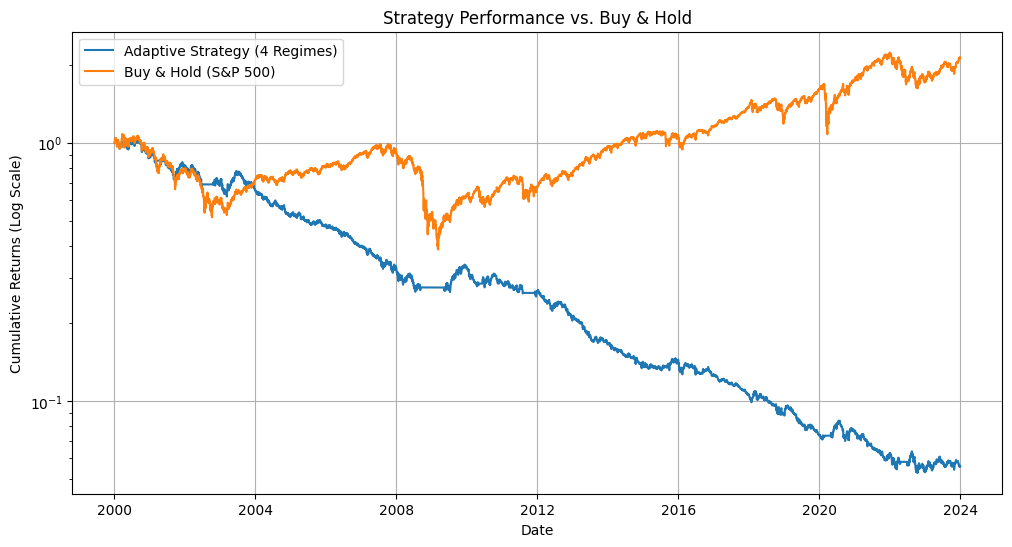

Backtest: Plot displayed.


In [28]:
import numpy as np
import pandas as pd
import yfinance as yf
# Ensure the correct import path for newer statsmodels versions
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
# Assuming matplotlib is available for plotting
import matplotlib.pyplot as plt
import traceback # For detailed error printing

# --- Configuration ---
ticker = '^GSPC'
start_date = '2000-01-01'
end_date = '2024-01-01'
n_regimes = 4 # <<< Changed to 4 regimes
risk_free_rate_annual = 0.01 # Annual risk-free rate for Sharpe calculation

# --- Data Acquisition & Regime Modeling ---
# Replicate data loading and MS modeling to get the target 'Regime' column
# This section MUST handle potential MultiIndex columns correctly.
data = pd.DataFrame() # Initialize data as empty DataFrame
price_column = None # Initialize price_column
log_returns_clean = pd.Series(dtype=float) # Initialize log_returns_clean
model_ready = False # Flag to track if data prep and MS model succeeded

try:
    # Download data
    data_raw = yf.download(ticker, start=start_date, end=end_date)
    if data_raw.empty:
        raise ValueError(f"Failed to download data for {ticker}. DataFrame is empty.")
    print("Backtest: Data downloaded successfully.")
    data = data_raw.copy() # Work with a copy

    # --- Handle Potential MultiIndex ---
    if isinstance(data.columns, pd.MultiIndex):
        print("Backtest: Detected MultiIndex columns. Attempting to simplify...")
        original_columns = data.columns.tolist()
        data.columns = ['_'.join(map(str, col)).strip() for col in data.columns.values]
        print(f"Backtest: Flattened columns: {data.columns}")
        # Find the correct price column name after flattening
        adj_close_flat = 'Adj Close' + '_' + ticker
        close_flat = 'Close' + '_' + ticker
        possible_price_cols = [col for col in data.columns if 'Adj Close' in col or 'Close' in col]

        if adj_close_flat in data.columns:
             price_column_flat = adj_close_flat
        elif close_flat in data.columns:
             price_column_flat = close_flat
        elif possible_price_cols:
             price_column_flat = possible_price_cols[0]
             print(f"Backtest: Warning: Using fallback flattened price column: {price_column_flat}")
        else:
             raise KeyError(f"Backtest: Could not find 'Adj Close' or 'Close' column after flattening. Original cols: {original_columns}, Flattened cols: {data.columns}")
        price_column = price_column_flat
        print(f"Backtest: Using flattened price column: {price_column}")
    else:
        # --- Standard Column Name Handling ---
        print("Backtest: Detected standard Index columns.")
        if 'Adj Close' in data.columns:
            price_column = 'Adj Close'
        elif 'Close' in data.columns:
            price_column = 'Close'
            print("Backtest: Warning: 'Adj Close' not found. Using 'Close' column instead.")
        else:
            raise KeyError("Backtest: Required price column ('Adj Close' or 'Close') not found.")
        print(f"Backtest: Using price column: {price_column}")

    # --- Calculate Log Returns ---
    # Ensure price column is numeric
    data[price_column] = pd.to_numeric(data[price_column], errors='coerce')
    if data[price_column].isnull().all():
        raise TypeError(f"Backtest: Price column '{price_column}' became all NaNs after coercion.")
    data['Log_Returns'] = np.log(data[price_column] / data[price_column].shift(1))

    # --- Clean Data for MS Model ---
    # Drop NaNs from price column (if any from coercion) and Log_Returns
    data = data.dropna(subset=[price_column, 'Log_Returns'])
    if len(data) < 50 * n_regimes: # Adjusted min data check
        raise ValueError(f"Backtest: Insufficient data ({len(data)} rows) for {n_regimes}-regime MS model after initial cleaning.")

    # --- Fit Markov Switching Model (to generate target variable 'Regime') ---
    print(f"Backtest: Fitting {n_regimes}-regime MS model to generate regimes...")
    log_returns_clean = data['Log_Returns'].dropna() # Should already be clean, but double-check
    if log_returns_clean.empty:
         raise ValueError("Backtest: Log_Returns series is empty before MS model fitting.")

    ms_model = MarkovRegression(log_returns_clean, k_regimes=n_regimes, trend='c', switching_variance=True) # Use n_regimes
    # Use same fitting params as standalone script for consistency
    ms_result = ms_model.fit(maxiter=1000, search_reps=10, disp='off')
    print("Backtest: MS model fitting complete.")

    # --- IMPORTANT: INTERPRET THE REGIMES (from MS Model script output) ---
    # Before proceeding, review the 'const' and 'sigma2' values for regimes 0, 1, 2, 3
    # from the Markov Switching Model script's summary output.
    # This interpretation is CRUCIAL for defining the strategy logic below.
    # Example Interpretation (Replace with your findings):
    # Regime 0: Low Vol, Low/Neg Drift -> Accumulation/Distribution?
    # Regime 1: Low Vol, High Pos Drift -> Advance
    # Regime 2: High Vol, Low/Neg Drift -> Distribution/Decline?
    # Regime 3: Very High Vol, Neg Drift -> Decline/Crash

    # Assign regimes back to the main 'data' DataFrame
    smoothed_probs = ms_result.smoothed_marginal_probabilities
    smoothed_probs.index = log_returns_clean.index # Align index
    data['Regime'] = smoothed_probs.idxmax(axis=1) # Assign target variable (0, 1, 2, 3)
    data = data.dropna(subset=['Regime']) # Drop any rows where regime assignment failed (unlikely)
    print("Backtest: Regimes assigned to DataFrame.")
    model_ready = True # Set flag indicating data prep and MS model succeeded

except Exception as e:
    print(f"Error during initial data prep/model: {e}")
    print("--- Traceback ---")
    traceback.print_exc()
    # Ensure data is empty if prep fails
    data = pd.DataFrame()
    model_ready = False


# --- Strategy Definition & Backtesting (only if model_ready is True) ---
if model_ready and not data.empty:
    try:
        print("Backtest: Defining signal and calculating strategy returns...")
        # --- Strategy Definition (4 Regimes) ---
        # Define the trading signal based on the identified regime.
        # This requires interpreting the regimes found by the MS model.

        # <<< --- !!! ACTION REQUIRED: DEFINE YOUR STRATEGY LOGIC HERE !!! --- >>>
        # Based on your interpretation of regimes 0, 1, 2, 3 from the MS model summary:
        # Assign a signal: 1 for Long, -1 for Short, 0 for Flat/Cash.
        # Example Placeholder Logic (REPLACE THIS WITH YOUR ACTUAL LOGIC):
        # Assume Regime 1 = Advance (Go Long)
        # Assume Regime 3 = Decline (Go Short)
        # Assume Regime 0 = Accumulation? (Go Flat/Neutral)
        # Assume Regime 2 = Distribution? (Go Flat/Neutral)
        regime_to_signal_map = {
            0: 0,  # Placeholder: Flat in Regime 0
            1: 1,  # Placeholder: Long in Regime 1
            2: 0,  # Placeholder: Flat in Regime 2
            3: -1  # Placeholder: Short in Regime 3
        }
        print(f"Backtest: Using Regime->Signal Map: {regime_to_signal_map}")
        # <<< --- END OF ACTION REQUIRED SECTION --- >>>

        # Apply the mapping to create the Signal column
        # Use the 'Regime' column determined by the MS model fit within this script.
        # To use predicted regimes, you would load the 'Predicted_Regime_LGBM'
        # column (e.g., from a saved file) and use that instead of 'Regime'.
        if 'Regime' not in data.columns:
             raise KeyError("Backtest: 'Regime' column not found after MS model processing.")

        data['Signal'] = data['Regime'].map(regime_to_signal_map).fillna(0) # Default to flat if map fails

        # --- Backtesting ---
        # Calculate strategy returns. Shift signal by 1 day.
        data['Strategy_Returns'] = data['Signal'].shift(1) * data['Log_Returns']

        # Drop initial NaN values
        data = data.dropna(subset=['Strategy_Returns'])
        print(f"Backtest: Strategy returns calculated. Data rows after NaNs: {len(data)}")

        if data.empty:
            raise ValueError("Backtest: DataFrame became empty after calculating Strategy_Returns and dropping NaNs.")

        # --- Performance Calculation ---
        print("Backtest: Calculating performance metrics...")
        # Calculate cumulative returns
        data['Cumulative_Strategy_Returns'] = (1 + data['Strategy_Returns']).cumprod()
        data['Cumulative_BH_Returns'] = (1 + data['Log_Returns'].loc[data.index]).cumprod()

        # --- Performance Metrics ---
        # Calculate daily risk-free rate
        risk_free_rate_daily = (1 + risk_free_rate_annual)**(1/252) - 1
        data['Excess_Strategy_Returns'] = data['Strategy_Returns'] - risk_free_rate_daily

        # 1. Sharpe Ratio
        sharpe_ratio = np.nan
        std_dev_excess = data['Excess_Strategy_Returns'].std()
        if std_dev_excess > 1e-9:
            sharpe_ratio = (data['Excess_Strategy_Returns'].mean() / std_dev_excess) * np.sqrt(252)
        else:
            print("Backtest: Warning - Standard deviation of excess returns is zero or near-zero. Sharpe Ratio is undefined.")

        # 2. Maximum Drawdown
        cumulative_returns = data['Cumulative_Strategy_Returns']
        rolling_max = cumulative_returns.cummax()
        drawdown = (cumulative_returns - rolling_max) / rolling_max
        max_drawdown = drawdown.min()

        # 3. Calmar Ratio & Annualized Return
        calmar_ratio = np.nan
        annualized_return = np.nan # Initialize as NaN
        total_days = (data.index[-1] - data.index[0]).days

        if data.empty:
             print("Backtest: Warning - Data is empty before calculating annualized return.")
        elif total_days >= 365:
            years = total_days / 365.25
            final_cumulative_return = data['Cumulative_Strategy_Returns'].iloc[-1]
            if final_cumulative_return > 0:
                 # Calculate annualized return using geometric mean
                 annualized_return = final_cumulative_return**(1/years) - 1
                 if abs(max_drawdown) > 1e-9:
                     calmar_ratio = annualized_return / abs(max_drawdown)
                 else:
                      print("Backtest: Warning - Maximum Drawdown is zero or near-zero. Calmar Ratio is undefined.")
            else:
                 # Handle cases where strategy ends with non-positive value
                 annualized_return = -1.0 # Or some other indicator of failure
                 print("Backtest: Warning - Final cumulative strategy return is non-positive. Cannot calculate meaningful annualized return or Calmar ratio.")
        else:
            # Less than a year - report total return
            annualized_return = data['Cumulative_Strategy_Returns'].iloc[-1] - 1
            print("Backtest: Warning - Data duration is less than a year. Reporting total return instead of annualized.")
            if abs(max_drawdown) > 1e-9:
                 calmar_ratio = annualized_return / abs(max_drawdown) # Calmar based on total return
            else:
                 print("Backtest: Warning - Maximum Drawdown is zero or near-zero. Calmar Ratio is undefined.")


        # --- Output Results ---
        print("\n--- Backtesting Performance Metrics (4 Regimes) ---")
        print(f"Strategy Signal Map Used: {regime_to_signal_map}")
        print(f"Annualized Return: {annualized_return:.4f}")
        print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
        print(f"Maximum Drawdown: {max_drawdown:.4f}")
        print(f"Calmar Ratio: {calmar_ratio:.4f}")
        # Ensure data is not empty before accessing iloc[-1]
        if not data.empty:
             print(f"Final Cumulative Strategy Return: {data['Cumulative_Strategy_Returns'].iloc[-1]:.4f}")
             print(f"Final Cumulative Buy & Hold Return: {data['Cumulative_BH_Returns'].iloc[-1]:.4f}")
        else:
             print("Final Cumulative Returns: N/A (Data Empty)")


        # --- Plotting ---
        if not data.empty:
            print("Backtest: Plotting results...")
            plt.figure(figsize=(12, 6))
            plt.plot(data['Cumulative_Strategy_Returns'], label='Adaptive Strategy (4 Regimes)')
            plt.plot(data['Cumulative_BH_Returns'], label='Buy & Hold (S&P 500)')
            plt.title('Strategy Performance vs. Buy & Hold')
            plt.xlabel('Date')
            plt.ylabel('Cumulative Returns (Log Scale)')
            plt.yscale('log') # Use log scale for better visualization
            plt.legend()
            plt.grid(True)
            plt.show()
            print("Backtest: Plot displayed.")
        else:
            print("Backtest: Skipping plot as data is empty.")

    except Exception as e:
        print(f"Error during Strategy Definition, Backtesting, or Plotting: {e}")
        print("--- Traceback ---")
        traceback.print_exc()

else:
    print("Skipping Strategy Backtesting because initial data preparation failed or data is empty.")

